line_loading_0     24.223041
line_loading_1     24.223041
line_loading_2     22.602009
line_loading_3     16.389209
line_loading_4     16.389209
line_loading_5      9.861251
line_loading_6      9.861251
line_loading_7      9.861251
line_loading_8      5.744952
line_loading_9      1.621973
line_loading_10     6.212839
line_loading_11     6.212839
line_loading_12     6.212839
line_loading_13     6.212839
line_loading_14     6.527961
line_loading_15     4.116592
line_loading_16     5.744952
line_power_0        0.151198
line_power_1        0.150200
line_power_2        0.139360
line_power_3        0.100373
line_power_4        0.099916
line_power_5        0.059855
line_power_6        0.059690
line_power_7        0.059524
line_power_8        0.034678
line_power_9        0.009842
line_power_10       0.038118
line_power_11       0.037785
line_power_12       0.037452
line_power_13       0.037119
line_power_14       0.039604
line_power_15       0.024681
line_power_16       0.034622
trafo_loading_

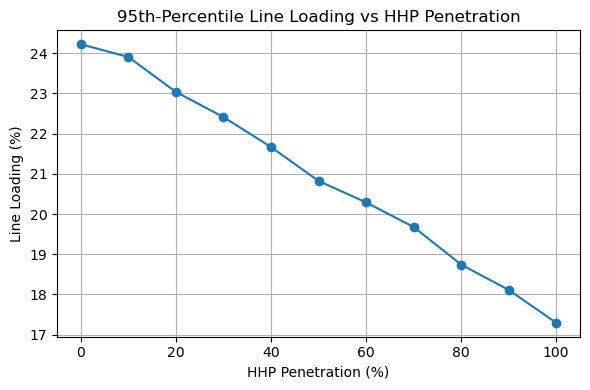

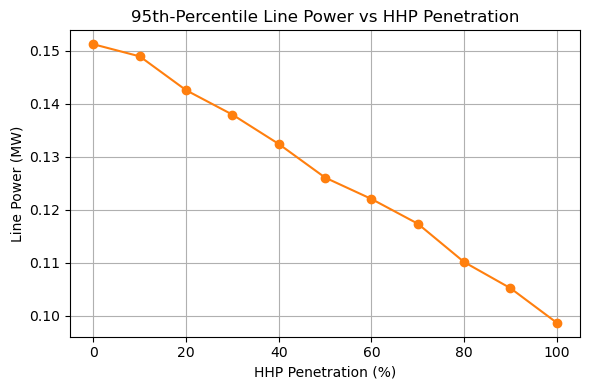

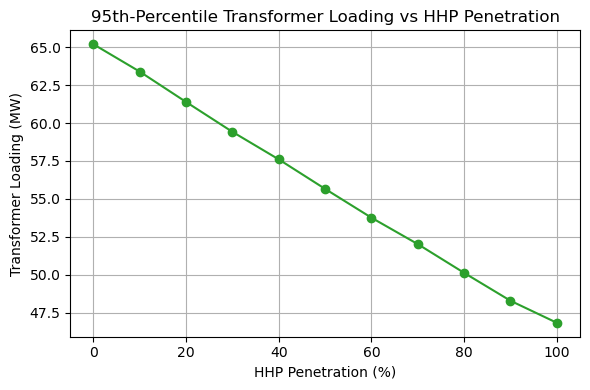

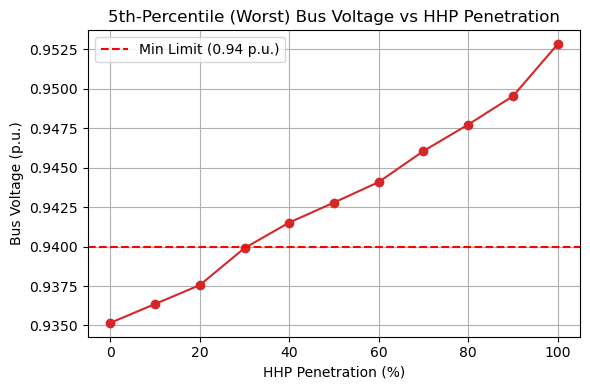

In [5]:
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt

# 1) Find all your Monte Carlo result files
#    assuming they live in ./output/ and are named like "..._HHP_20p_100samples.csv"
files = glob.glob(r"E:\GitHubProjects\LV network\Codes\Output/montecarlo_results_HHP_*p_*samples.csv")

records = []
n=0
for fn in files:
    # 2) Extract HHP penetration from filename, handles e.g. "..._HHP_70p_10samples.csv"
    m = re.search(r"_HHP_(\d{1,3})p_", fn)
    if not m:
        continue
    perc = int(m.group(1)) / 100.0

    # 3) Load data
    df = pd.read_csv(fn)

    # 4) Compute 95th percentile per column
    pct95 = df.quantile(0.95)
    pct05 = df.quantile(0.05)
    while n==0:
        print(pct95)
        n += 2
    # 5) Collapse metrics
    line_loading_95 = pct95.filter(like="line_loading_").max()
    line_power_95   = pct95.filter(like="line_power_").max()
    trafo_loading_95 = pct95.filter(like="trafo_loading_").max()
    bus_voltage_05  = pct05.filter(like="bus_voltage_").min()

    records.append({
        "hhp_pct": perc * 100,
        "line_loading_95": line_loading_95,
        "line_power_95": line_power_95,
        "trafo_loading_95": trafo_loading_95,
        "bus_voltage_05": bus_voltage_05
    })

# 6) Build DataFrame
df_results = pd.DataFrame(records).sort_values("hhp_pct").set_index("hhp_pct")

# 7) Plot

# assume df_results is already built and indexed by hhp_pct

# 1) Line Loading (%)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["line_loading_95"], marker='o')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Line Loading (%)")
plt.title("95th‐Percentile Line Loading vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 2) Line Power (MW)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["line_power_95"], marker='o', color='C1')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Line Power (MW)")
plt.title("95th‐Percentile Line Power vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 3) Transformer Loading (%)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["trafo_loading_95"], marker='o', color='C2')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Transformer Loading (MW)")
plt.title("95th‐Percentile Transformer Loading vs HHP Penetration")
plt.grid(True)
plt.tight_layout()

# 4) Worst‐Case Bus Voltage (p.u.)
plt.figure(figsize=(6,4))
plt.plot(df_results.index, df_results["bus_voltage_05"], marker='o', color='C3')
plt.xlabel("HHP Penetration (%)")
plt.ylabel("Bus Voltage (p.u.)")
plt.title("5th‐Percentile (Worst) Bus Voltage vs HHP Penetration")
plt.axhline(0.94, color='red', linestyle='--', label='Min Limit (0.94 p.u.)')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

